In [11]:
# ================================
# Step 1: Import libraries
# ================================
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import fpgrowth, association_rules

In [13]:
# ================================
# Step 2: Load dataset
# ================================
file_path = "/Bank_Transaction_Fraud_Detection.csv"  # adjust if needed
df = pd.read_csv(file_path)

print("Original shape:", df.shape)

Original shape: (200000, 24)


In [14]:
# ================================
# Step 3: Drop unwanted columns
# ================================
drop_cols = [
    "Customer_ID", "Customer_Name", "Transaction_ID", "Merchant_ID",
    "Customer_Contact", "Customer_Email", "Transaction_Description",
    "Bank_Branch", "Transaction_Currency", "City",
    "Transaction_Date", "Transaction_Location"  # now explicit
]
df.drop(columns=drop_cols, inplace=True, errors="ignore")
print("Shape after dropping unwanted columns:", df.shape)


Shape after dropping unwanted columns: (200000, 12)


In [15]:
# ================================
# Step 4: Bin continuous variables
# ================================

# --- Age bins ---
age_bins = [0, 25, 40, 60, np.inf]
age_labels = ["<25", "25-40", "40-60", "60+"]
df["Age_Bin"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)

# --- Transaction Amount bins ---
amt_bins = np.linspace(df["Transaction_Amount"].min(), df["Transaction_Amount"].max(), 4)
amt_labels = ["Low", "Medium", "High"]
df["Amount_Bin"] = pd.cut(df["Transaction_Amount"], bins=amt_bins, labels=amt_labels, include_lowest=True)
print("Transaction Amount bin ranges:", amt_bins)

# --- Account Balance bins ---
bal_bins = np.linspace(df["Account_Balance"].min(), df["Account_Balance"].max(), 4)
bal_labels = ["Low", "Medium", "High"]
df["Balance_Bin"] = pd.cut(df["Account_Balance"], bins=bal_bins, labels=bal_labels, include_lowest=True)
print("Account Balance bin ranges:", bal_bins)

# --- Transaction Time bins ---
# Convert Transaction_Time safely
if df["Transaction_Time"].dtype == "object":
    # Try to parse HH:MM:SS format
    df["Transaction_Time"] = pd.to_datetime(df["Transaction_Time"], errors="coerce").dt.hour.fillna(
        pd.to_numeric(df["Transaction_Time"], errors="coerce")
    )

# Function for binning time of day
def time_of_day(x):
    if pd.isna(x):
        return np.nan
    if 5 <= x < 12:
        return "Morning"
    elif 12 <= x < 17:
        return "Afternoon"
    elif 17 <= x < 21:
        return "Evening"
    else:
        return "Night"

df["Time_Bin"] = df["Transaction_Time"].apply(time_of_day)

Transaction Amount bin ranges: [1.02900000e+01 3.30068533e+04 6.60034167e+04 9.89999800e+04]
Account Balance bin ranges: [ 5000.82       36667.19666667 68333.57333333 99999.95      ]


/tmp/ipython-input-3953427109.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Transaction_Time"] = pd.to_datetime(df["Transaction_Time"], errors="coerce").dt.hour.fillna(


In [16]:

# ================================
# Step 5: Keep only useful features
# ================================
keep_cols = [
    "Gender", "State", "Account_Type", "Transaction_Type", "Merchant_Category",
    "Transaction_Device", "Device_Type", "Is_Fraud",
    "Age_Bin", "Amount_Bin", "Balance_Bin", "Time_Bin"
]
df = df[keep_cols]

print("Final shape after selecting features:", df.shape)

Final shape after selecting features: (200000, 12)


In [17]:
# ================================
# Step 6: Handle missing values
# ================================
print("Missing values per column:\n", df.isna().sum())
df.dropna(inplace=True)
print("Shape after dropping missing rows:", df.shape)

Missing values per column:
 Gender                0
State                 0
Account_Type          0
Transaction_Type      0
Merchant_Category     0
Transaction_Device    0
Device_Type           0
Is_Fraud              0
Age_Bin               0
Amount_Bin            0
Balance_Bin           0
Time_Bin              0
dtype: int64
Shape after dropping missing rows: (200000, 12)


In [18]:
# ================================
# Step 7: Hybrid Balancing
# ================================
fraud_df = df[df["Is_Fraud"] == 1]
nonfraud_df = df[df["Is_Fraud"] == 0]

print("Fraud cases:", len(fraud_df))
print("Non-Fraud cases:", len(nonfraud_df))

# Hybrid approach: keep all fraud, sample some non-fraud
nonfraud_sample = nonfraud_df.sample(
    n=min(len(nonfraud_df), len(fraud_df) * 3),  # 3x fraud size
    random_state=42
)

balanced_df = pd.concat([fraud_df, nonfraud_sample], axis=0).sample(frac=1, random_state=42)
print("Balanced dataset shape:", balanced_df.shape)

Fraud cases: 10088
Non-Fraud cases: 189912
Balanced dataset shape: (40352, 12)


In [19]:
# ================================
# Step 8: Transform into basket format
# ================================
basket = pd.get_dummies(balanced_df.astype(str))
print("Basket shape:", basket.shape)
basket.head()

Basket shape: (40352, 90)


,Gender_Female,Gender_Male,State_Andaman and Nicobar Islands,State_Andhra Pradesh,State_Arunachal Pradesh,State_Assam,State_Bihar,State_Chandigarh,State_Chhattisgarh,State_Dadra and Nagar Haveli and Daman and Diu,...,Amount_Bin_High,Amount_Bin_Low,Amount_Bin_Medium,Balance_Bin_High,Balance_Bin_Low,Balance_Bin_Medium,Time_Bin_Afternoon,Time_Bin_Evening,Time_Bin_Morning,Time_Bin_Night
77899,False,True,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
83853,False,True,False,True,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
43434,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
127162,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True
88581,True,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,False,False


In [20]:
# ================================
# Step 9: Apply FP-Growth
# ================================
frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)  # now 1% support
frequent_itemsets.sort_values(by="support", ascending=False, inplace=True)

print("Top 10 frequent itemsets:")
print(frequent_itemsets.head(10))

Top 10 frequent itemsets:
       support                     itemsets
0     0.750000                 (Is_Fraud_0)
1     0.500966                (Gender_Male)
22    0.499034              (Gender_Female)
2     0.377652              (Age_Bin_40-60)
90    0.375050    (Is_Fraud_0, Gender_Male)
4779  0.374950  (Gender_Female, Is_Fraud_0)
3     0.336266      (Account_Type_Business)
23    0.334531             (Amount_Bin_Low)
12    0.334482          (Amount_Bin_Medium)
30    0.334407      (Account_Type_Checking)


In [21]:
# ================================
# Step 10: Generate association rules
# ================================
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules.sort_values(by="lift", ascending=False, inplace=True)

print("Top 20 rules by lift:")
print(rules.head(20))

Top 20 rules by lift:
                                             antecedents  \
57585  (Gender_Female, Age_Bin_40-60, Transaction_Typ...   
57588   (Is_Fraud_0, Transaction_Device_ATM Booth Kiosk)   
57581  (Is_Fraud_0, Transaction_Device_ATM Booth Kios...   
57592       (Gender_Female, Transaction_Type_Withdrawal)   
57580  (Is_Fraud_0, Transaction_Device_ATM Booth Kios...   
57593       (Age_Bin_40-60, Transaction_Type_Withdrawal)   
57584  (Is_Fraud_0, Age_Bin_40-60, Transaction_Type_W...   
57589  (Gender_Female, Transaction_Device_ATM Booth K...   
57597               (Transaction_Device_ATM Booth Kiosk)   
57576  (Is_Fraud_0, Age_Bin_40-60, Gender_Female, Tra...   
57590  (Age_Bin_40-60, Transaction_Device_ATM Booth K...   
57583  (Is_Fraud_0, Gender_Female, Transaction_Type_W...   
50182    (Transaction_Device_ATM, Account_Type_Business)   
50187         (Transaction_Type_Withdrawal, Gender_Male)   
46288  (Transaction_Device_Self-service Banking Machine)   
46285  (Merchant_C

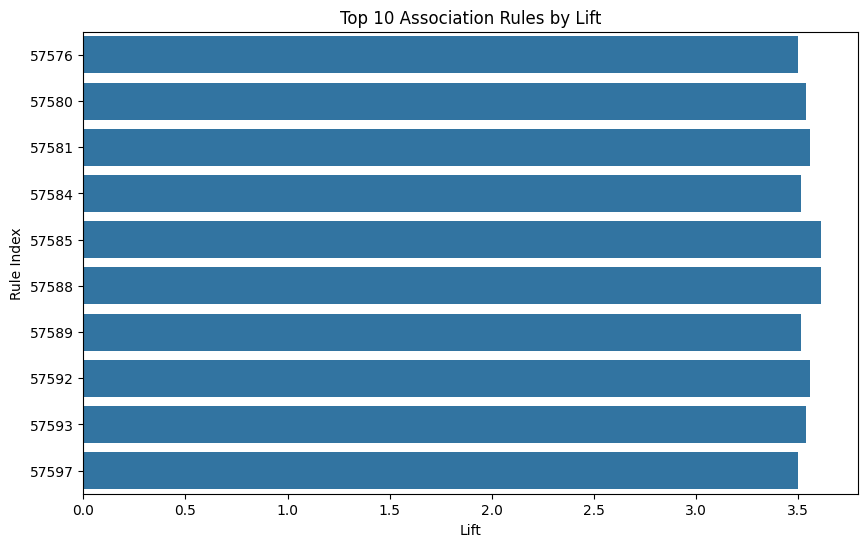

In [22]:
# ================================
# Step 11: Visualization
# ================================
top_rules = rules.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x="lift", y=top_rules.index, data=top_rules, orient="h")
plt.title("Top 10 Association Rules by Lift")
plt.xlabel("Lift")
plt.ylabel("Rule Index")
plt.show()


In [23]:
# ================================
# Step 12: Fraud-specific rules
# ================================
fraud_rules = rules[rules["consequents"].astype(str).str.contains("Is_Fraud_1")]
print("Fraud-related rules:")
print(fraud_rules.head(10))

Fraud-related rules:
                                             antecedents  \
22520               (Transaction_Device_ATM Booth Kiosk)   
22521                      (Transaction_Type_Withdrawal)   
25569                      (Transaction_Type_Withdrawal)   
25568                           (Transaction_Device_ATM)   
24586  (Transaction_Device_Self-service Banking Machine)   
24587                      (Transaction_Type_Withdrawal)   
62156        (Balance_Bin_Medium, Account_Type_Business)   
63106                        (Transaction_Type_Transfer)   
62154            (Balance_Bin_Medium, Amount_Bin_Medium)   
53341     (Device_Type_ATM, Time_Bin_Night, Gender_Male)   

                                             consequents  antecedent support  \
22520          (Transaction_Type_Withdrawal, Is_Fraud_1)            0.106661   
22521   (Transaction_Device_ATM Booth Kiosk, Is_Fraud_1)            0.198008   
25569               (Transaction_Device_ATM, Is_Fraud_1)            0.198008  

/tmp/ipython-input-1725871642.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


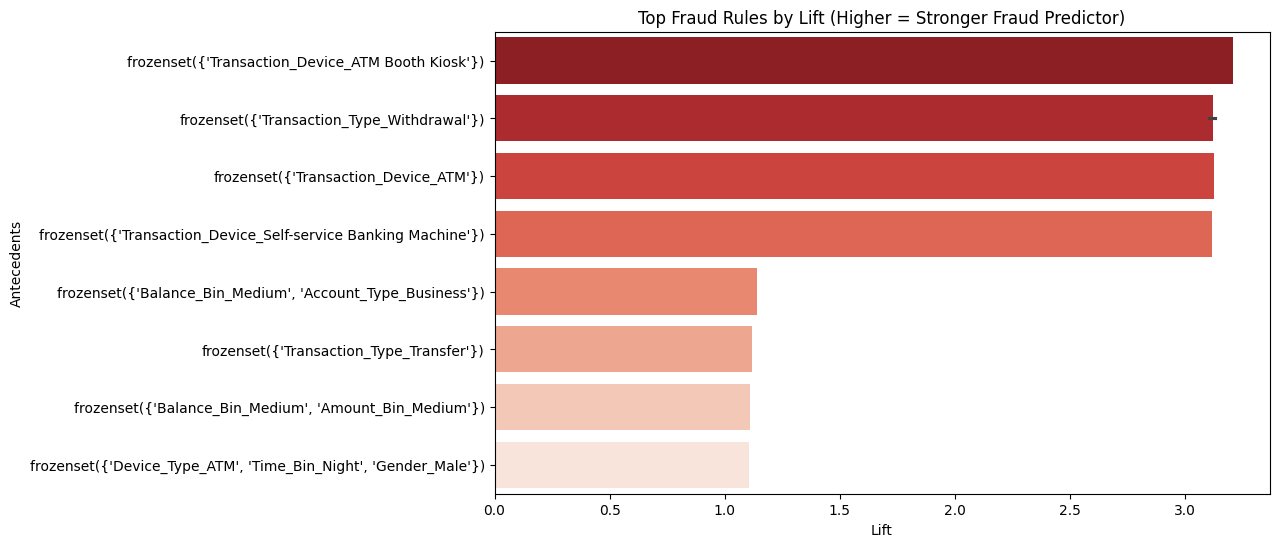

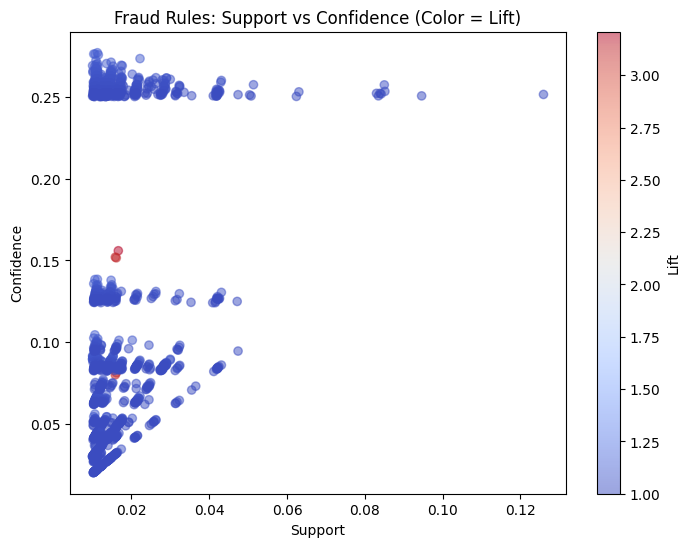

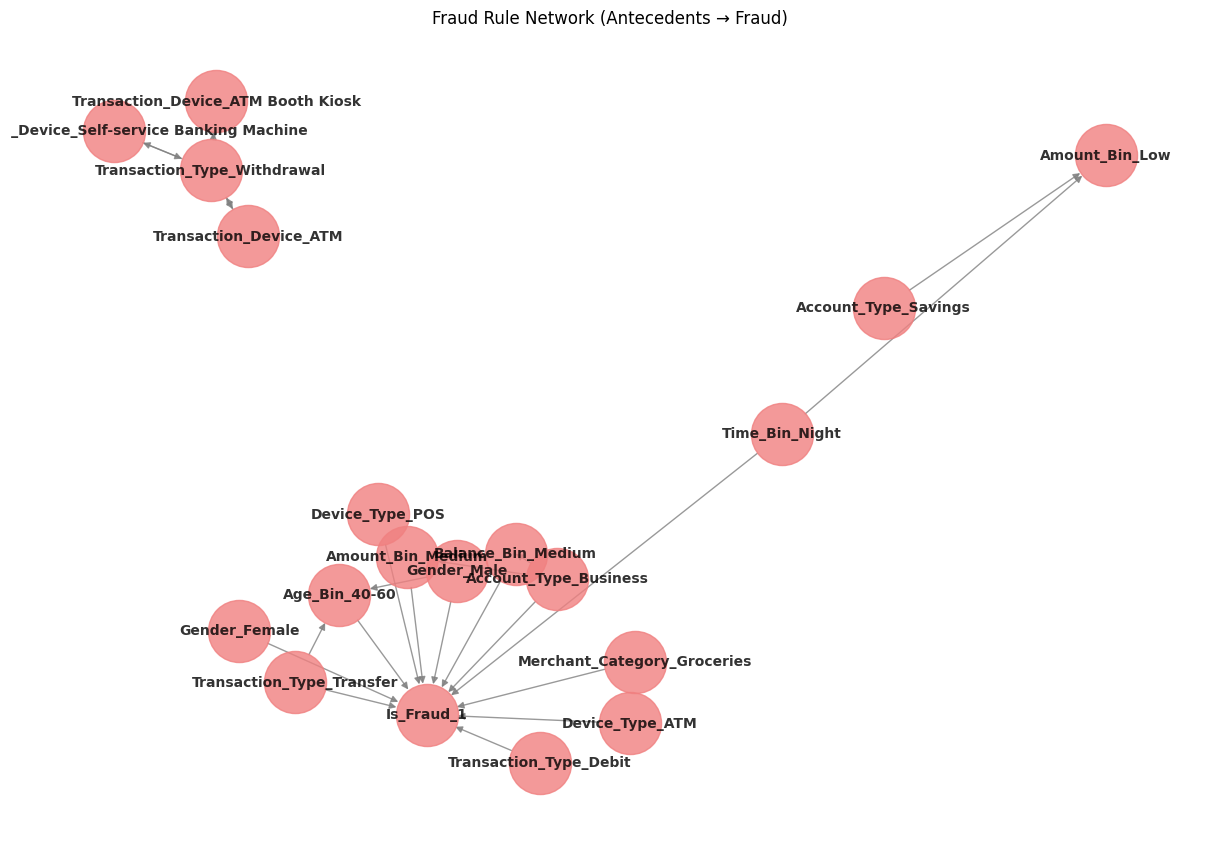

In [24]:
# ================================
# Fraud-Focused Visualizations
# ================================

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Make sure we only look at fraud rules
fraud_rules = rules[rules["consequents"].astype(str).str.contains("Is_Fraud_1")]

# --------------------------------
# 1. Bar Chart of Top Fraud Rules by Lift
# --------------------------------
top_fraud_rules = fraud_rules.sort_values("lift", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x="lift",
    y=top_fraud_rules["antecedents"].astype(str),
    data=top_fraud_rules,
    palette="Reds_r"
)
plt.title("Top Fraud Rules by Lift (Higher = Stronger Fraud Predictor)")
plt.xlabel("Lift")
plt.ylabel("Antecedents")
plt.show()


# --------------------------------
# 2. Support vs Confidence Scatter Plot
# --------------------------------
plt.figure(figsize=(8,6))
plt.scatter(
    fraud_rules["support"],
    fraud_rules["confidence"],
    alpha=0.5,
    c=fraud_rules["lift"],
    cmap="coolwarm"
)
plt.colorbar(label="Lift")
plt.title("Fraud Rules: Support vs Confidence (Color = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()


# --------------------------------
# 3. Network Graph of Fraud Rules
# --------------------------------
# Limit to top 20 rules by lift for clarity
top_network_rules = fraud_rules.sort_values("lift", ascending=False).head(20)

# Build graph
G = nx.DiGraph()
for _, row in top_network_rules.iterrows():
    for antecedent in row["antecedents"]:
        G.add_edge(str(antecedent), str(list(row["consequents"])[0]), weight=row["lift"])

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Draw nodes and edges
nx.draw(
    G, pos, with_labels=True, node_size=2000,
    node_color="lightcoral", font_size=10, font_weight="bold",
    edge_color="gray", arrows=True, alpha=0.8
)

plt.title("Fraud Rule Network (Antecedents → Fraud)")
plt.show()
